<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/3_DeepLearning/13-3_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EC%A0%95%EC%B1%85%EA%B2%BD%EC%82%AC%EB%B2%95_sarsa_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정책 경사법을 활용한 미로 게임

- 정책 계산 방법 > 정책 반복법 > 정책 경사법
  - 행동을 중시
  - 정책을 갱신 => 정책 기준으로 행동을 수행

# 가치 반복법을 활용한 미로게임

- 정책 계산 방법 > 가치 반복법 > Sarsa(살사), Q Learning(큐러닝)
  - 가치를 중시
  - 정책을 갱신 => 정책 기준으로 행동을 수행

# 미로게임


- 미로 게임은 입구와 출구가 각각 1개만 존재
- 바둑판과 같은 사격형에 열린 곳과 막힌 곳이 존재
- 에이전트(마우스, 쥐)는 4방향으로 이동이 가능
  - 상:0, 우:1, 하:2, 좌:3 
  - 시계 방향으로 수치를 배치
- 게임판 수직에서 밑으로 투시해서 보는 직각으로 보는 뷰로 설정
- 게임판 3x3
  - 바둑판은 9칸
- 목적
  - 에이전트는 최단거리로 입구에서 출발하여 출구로 나간다

In [ ]:
# 모듈 가져오기
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

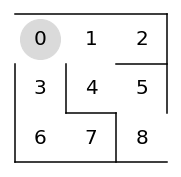

In [ ]:
# 게임판 그리기
fig = plt.figure( figsize=(3,3) )

# 외곽 벽그리기
plt.plot( [0,3], [3,3], color='k') # 맨위 수평선
plt.plot( [0,3], [0,0], color='k') # 맨아래 수평선
plt.plot( [0,0], [0,2], color='k') # 왼쪽 수직선, 입구 표시
plt.plot( [3,3], [1,3], color='k') # 오른쪽 수직선, 출구 표시

# 내부 벽 그리기
plt.plot( [1,1], [1,2], color='k') 
plt.plot( [2,3], [2,2], color='k')
plt.plot( [1,2], [1,1], color='k')
plt.plot( [2,2], [0,1], color='k')

# 각 포인트에 숫자 표현
for n in range( 3 ):
  for m in range( 3 ):
      plt.text( n+0.5, 3-m-0.5, str(n+m*3), size=20, ha='center', va='center' )

# 에이전트 그리기
mouse = plt.plot( 0.5, 2.5, marker='o', color='#dadada', markersize=40 )

# 눈금 정리 -> 제거
plt.tick_params( 
                #axis='both', 
                #which='both', 
                 bottom=False, left=False, #right=False, top=False, 
                 labelbottom=False, labelleft=False
                )

plt.box(False)
plt.show()

## 미션/목적

- 에이전트가 시작지점(0번)에서 상우하좌로 이동하여, 골인 지점(8번 위치)까지 최단거리로 이동하는 능력을 학습하는 것
  - 최단 거리 학습 (미로에서)

## 요소 설계

|강화 학습 요소|다중 슬롯머신의 내용|
|--:|:--|
|에이전트|미로속의 마우스|
|환경|미로|
|목적|0번위치에서 8번위치(골인지점)까지 최단거리로 이동|
|행동|상우하좌 이동, 4방향 존재|
|에피소드|8번위치에 도착하면, 미로를 탈출하면 종료됨|
|상태|에이전트의 위치|
|보상|골인 지점까지 이동하는 행동을 중시하겠다 -> 정책경사법을 활용|
|학습방법|정책 경사법|
|파라미터 변경 주기(정책 결정하는 측면)|- 정책 결정에 영향을 미치겠다(가중치)<BR>- 정책은 행동에 영향을 미친다<BR>- 각 포인트별로 갈 수 있는 곳과 갈 수 없는 곳에 대한 정보를 가지고 있고, 갈 수 있는 곳은 확률을 가지고 있다<BR>- 1 에피소드가 종료되면 파라미터를 갱신하겠다|

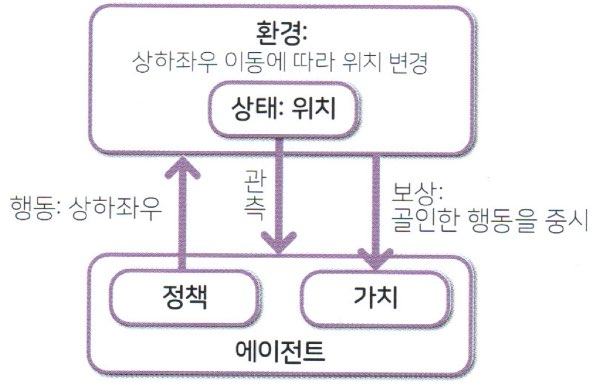

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/pic_rl/미로게임_학습사이클.jpg', width=400)

# 정책


- 에이전트의 상태 정의(미로상에서 취할 수 있는 행동 확률)
  - 특정 상태(에이전트가 미로상에 위치한 정보)에서 특정 행동(상우하좌)을 할 확률
  - 해당 확률을 매개변수 혹은 파라미터로 표현 가능
  - 이것을 묘사하면, 정책을 표현할 수 있다.
  

|구분|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|np.nan|1|1|np.nan|
|p1|np.nan|1|1|np.nan|
|p2|np.nan|np.nan|np.nan|1|
|p3|..||||
|p4|||||
|p5|||||
|p6|||||
|p7|||||
|p8||||..|

# 이런 정책을 softmax로 통과하면 

|구분|상|우|하|좌|
|:--:|:--:|:--:|:--:|:--:|
|p0|0|0.5|0.5|0|
|p1|0|0.5|0.5|0|
|p2|0|0|0|0.5|
|p3|..||||
|p4|||||
|p5|||||
|p6|||||
|p7|||||
|p8||||..|

# 파라미터 초기화(정책 초기값)

In [ ]:
theta_0 = np.array([
                    # [상, 우, 하, 좌]
                    [np.nan, 1, 1, np.nan],        # 0
                    [np.nan, 1, 1, 1],             # 1
                    [np.nan, np.nan, np.nan, 1],   # 2
                    [1, np.nan, 1,np.nan],         # 3
                    [1, 1, np.nan, np.nan],        # 4
                    [np.nan, np.nan, 1, 1],        # 5
                    [1, 1, np.nan, np.nan],        # 6
                    [np.nan, np.nan, np.nan, 1]    # 7
])

In [ ]:
# 에이전트가 특정 상태(미로상의 위치)에서 특정 행동(상우하좌로 이동한다는 행동)을 취할 확률
# 이것을 우리는 정책으로 보고, 에피소드가 종료되면 정책 갱신 -> 다시 에피소드 진행
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1.,  1.,  1.],
       [nan, nan, nan,  1.],
       [ 1., nan,  1., nan],
       [ 1.,  1., nan, nan],
       [nan, nan,  1.,  1.],
       [ 1.,  1., nan, nan],
       [nan, nan, nan,  1.]])

In [ ]:
# 확률로 표현
a = theta_0[0]
a

array([nan,  1.,  1., nan])

In [ ]:
a / np.sum(a)
# nan 들어가면 다 뭉개진다.

array([nan, nan, nan, nan])

In [ ]:
# nansum() => nan을 배제하고 계산
a / np.nansum(a)

array([nan, 0.5, 0.5, nan])

In [ ]:
# softmax 처리 직접 구현
def mySoftmax( theta ) :
  # 각각 1차원을 계산해서 결과를 담아서 리턴하겠다.
  # 모든 구성원의 값이 0인, theta와 동일한 크기의 배열을 생성
  output = np.zeros_like( theta )
  # 만약 큰 수를 이용한, 복잡한 범위를 가진 수치들을 가지고 계산한다면! -> 지수함수로 1차 처리 후 진행
  # e, 2.71, ...의 x제곱 등으로 표현(= 지수함수 치환)
  # 수치를 조정해서, 계산이 비교적 빠르게 처리되게끔 조정한다.
  # 여기서는 생략 가능
  theta = np.exp(theta)
  # 각각 1차원을 확률로 계산하여 output에 채운다.
  # 실습 => np.apply_along_axis 사용하는 방법도 연구  
  for i in range( theta.shape[0] ) : 
    output[i] = theta[i] / np.nansum( theta[i] )
    # 동일한 결과인데 iloc 사용 => output[i, :] = theta[i, :] / np.nansum(theta[i, :])
  return np.nan_to_num( output )

mySoftmax(theta_0)

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 1.        ],
       [0.5       , 0.        , 0.5       , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [ ]:
# 정책에 따른 행동 정보 획득
# policy : 에이전트가 특정 상태에서 특정 행동을 선택할 수 있는 정책
# state  : 에이전트의 현재 상태 -> 미로상에 에이전트가 어디에 위치해 있는가
def getAction( policy, state ) : 
  # 최종 리턴값 => [상:0 우:1 하:2 좌:3]
  return np.random.choice( [ 0, 1, 2, 3 ], p=policy[state] )

In [ ]:
# 행동에 따른 다음 상태(미로상의 위치 정보) 획득
# curState   : 현재 상태(행동을 취하려고 한다. 에이전트의 현재 위치는), 후보군은 0 ~ 7
# nextAction : 현재 상테에서 취하려고 하는 행동, 0 ~ 3
def getNextState( curState, nextAction ) :
  if nextAction == 0 :      # 상
    return curState - 3
  elif nextAction == 1 :    # 우
    return curState + 1
  elif nextAction == 2 :    # 하
    return curState + 3
  elif nextAction == 3 :    # 좌
    return curState - 1

In [ ]:
# 시뮬레이션을 위한 환경변수, 상수 정의
AGENT_FIRST_STATE = 0
# 에이전트가 AGENT_LAST_STATE로 상태값이 세팅되면 에피소드 종료 -> 판단 기준
AGENT_LAST_STATE = 8
# 최초 정책
theta = mySoftmax(theta_0)

In [ ]:
# 1 에피소드에 대한 시뮬레이션 함수
# updatePolicy : 매 에피소드마다 갱신된 정책이 반영된다. 인자로 전달
def simulation_miro_game( updatePolicy ) :
  # 에이전트가 이동한 로그를 기록 -> 데이터
  # [ [특정 상태, 다음 상태로 가기 위한 행동], ... ]
  # 에이전트의 최초 위치는 0, 다음 상태를 위한 행동은 결정된 바 없다(np.nan).
  st_act_his = [ [AGENT_FIRST_STATE, np.nan] ]
  # 편의상 에이전트의 현재 위치는 변수를 받아준다.
  cur_agent_state = AGENT_FIRST_STATE

  while True :
    # 1. 현재 상태(미로상의 위치)에서 정책에 따라 다음 행동을 구한다.
    agent_action = getAction(updatePolicy, cur_agent_state)
    # 2. 다음 행동에 따른 다음 상태(미로상의 위치) 획득
    next_agent_state = getNextState(cur_agent_state, agent_action)
    # 3. 행동에 대한 로그에 기록을 갱신 : 현재 상태에 대한 다음 행동을 기록
    # 로그 특성상 마지막 멤버의 마지막 멤버가 항상 np.nan
    st_act_his[-1][-1] = agent_action
    # 4. 행동에 대한 로그에 기록을 추가 : 다음 상태에 대한 기록을 추가
    st_act_his.append([ next_agent_state, np.nan ])

    # 에이전트의 상태(현재 혹은 다음)가 AGENT_LAST_STATE => 에피소드 종료
    cur_agent_state = next_agent_state
    if cur_agent_state == AGENT_LAST_STATE :    # 마우스(에이전트)는 8번 위치에 도착했다.
      break

  return st_act_his

In [ ]:
his = simulation_miro_game(theta)
his

[[0, 2],
 [3, 0],
 [0, 2],
 [3, 0],
 [0, 2],
 [3, 2],
 [6, 1],
 [7, 3],
 [6, 0],
 [3, 2],
 [6, 0],
 [3, 2],
 [6, 0],
 [3, 2],
 [6, 0],
 [3, 2],
 [6, 0],
 [3, 2],
 [6, 0],
 [3, 0],
 [0, 2],
 [3, 0],
 [0, 2],
 [3, 0],
 [0, 1],
 [1, 2],
 [4, 0],
 [1, 3],
 [0, 2],
 [3, 0],
 [0, 1],
 [1, 3],
 [0, 1],
 [1, 2],
 [4, 0],
 [1, 2],
 [4, 0],
 [1, 1],
 [2, 3],
 [1, 2],
 [4, 1],
 [5, 2],
 [8, nan]]

In [ ]:
# 에이전트가 미로를 탈출하기 위해 수행한 이동 횟수
len(his)

43

# 정책을 갱신하여 최단 이동을 통해서 탈출하게끔 행동을 강화하겠다 

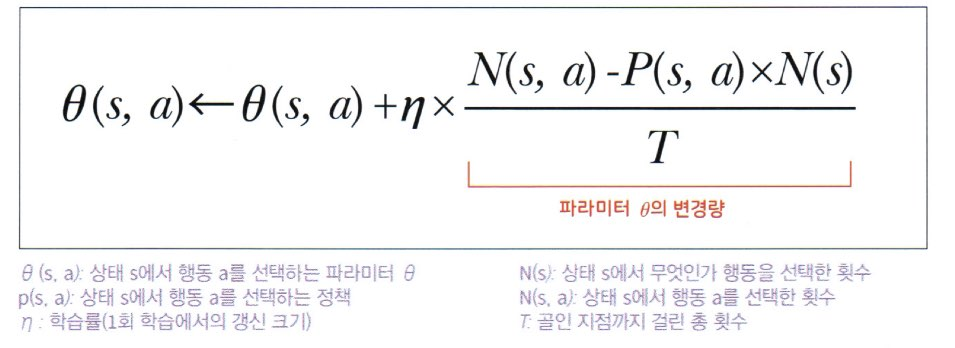

In [ ]:
# 정책을 갱신하는 식
Image('/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/pic_rl/파라미터세타변경량.jpeg')

# 정책 경사법에서 사용하는, 정책 갱신에 관련된 식
# 정책 갱신 = 원래 정책 + 학습률 * (파라미터 θ의 변경량)
#   => 각 상태에서 특정 행동을 취할 확률을 조정하겠다.
# T       : 에이전트의 이동 횟수, 골인 지점까지 걸린 총 횟수, 총 몇번 움직였다
# s       : 상태
# a       : 행동
# θ(s,a) : 상태 s에서 행동 a를 선택하는 파라미터 θ => 확률
# N(s,a)  : 상태 s에서 행동 a를 선택한 횟수          => 0번 위치에서 10번 이동했는데, 우측으로 3회, 아래로 7회 이동했다.
# P(s,a)  : 상태 s에서 행동 a를 선택하는 정책        => 확률값
# N(s)    : 상태 s에서 행동을 선택한 횟수            => (N(s,a) 설명 기준으로) 10번 
# η      : 학습률                                   => 설정하여 사용, 튜닝 포인트

In [ ]:
# 에피소드를 n번 수행하는 함수
# 에피소드 종료 후 -> 정책/가치 계산(정책 경사법을 활용) -> 정책을 갱신 -> 다음 에피소드 진행

# 정책 갱신 함수

In [ ]:
theta.shape

(8, 4)

In [ ]:
# theta_0    : 갱신되기 전 정책 or 파라미터로 정책을 가진 θ -> np.nan을 가진 원재료
# policy     : theta_0를 softmax로 통과시켜서 만든 정책값(확률을 가지고 있다.)
# st_act_his : 한번의 에피소드가 종료되면 나오는 에이전트의 이동 기록
def update_theta( theta_0, policy, st_act_his ) :
  # 학습률
  eta = 0.1                                 # 학습률(학습계수)은 θ 변동량의 10%만 정책에 증가시키겠다. 변동 가능.
  updateTheta = theta_0.copy()              # 정책 갱신 전 θ를 카피 떠서 for문을 돌리겠다.
  # 총 수행횟수(마지막 8번 상태는 제외한다 -> 다음 행동값이 없다.)
  T = len(st_act_his) - 1
  # 정책 갱신 : updateTheta 갱신
  state_cnt, action_cnt = theta.shape       # (8, 4)
  for s in range(state_cnt) :               # 상태의 총 개수
    for a in range(action_cnt) :            # 행동의 총 개수
      # 갱신대상이 아닌 0 혹은 np.nan은 계산에서 배제
      if not np.isnan( theta_0[s,a] ) :
      # if theta_0[s,a] :                   => 0이 아니면, np.nan이 아니면
        # 1을 넣는다면 len([1,1,1]) or sum([1,1,1]) => 3
        # 현재 상태 s에서 a라는 행동을 취한 개수를 모아서 카운트
        n_sa = len([ 1 for sah in st_act_his if sah == [s,a] ])
        p_sa = policy[s,a]
        # 현재 상태에서 행동을 몇번 했는가?
        n_s  = len([ 1 for sah in st_act_his if sah[0] == s ])
        # 파라미터 θ의 변경량
        updateTheta[s,a] = (n_sa - p_sa * n_s) / T

  # 갱신된 정책 리턴
  return theta_0 + eta * updateTheta

In [ ]:
update_theta(theta_0, theta, his)

array([[       nan, 0.99642857, 1.00357143,        nan],
       [       nan, 0.9968254 , 1.00396825, 0.99920635],
       [       nan,        nan,        nan, 1.        ],
       [1.        ,        nan, 1.        ,        nan],
       [1.00238095, 0.99761905,        nan,        nan],
       [       nan,        nan, 1.00119048, 0.99880952],
       [1.00595238, 0.99404762,        nan,        nan],
       [       nan,        nan,        nan, 1.        ]])

# 에피소드 1000번 적용하여 완성
- 1000번은 설정값

In [ ]:
# 환경변수
SIMULATE_COUNTS = 1000
# SIMULATE_COUNTS까지 다 구동되지 않아도, 변동량이 지정된 값보다 미비하면 그만하겠다.
EPISODE_STOP_VALUE = 10**-3

In [ ]:
for episode in range(SIMULATE_COUNTS) :
  # 1. 에피소드 수행
  a_s_his = simulation_miro_game( theta )
  # 2. 정책 갱신
  new_policy = update_theta(theta_0, theta, a_s_his)
  # 3. 정책의 변동량(혹은 변화량) 측정
  new_policy = mySoftmax(new_policy)
  policy_delta = np.nansum(np.abs(new_policy - theta))
  # 4. 정책 교체
  theta = new_policy
  # 5. 로그
  print(f'에피소드 {episode:10}, 정책변동량 {policy_delta}')
  # 변동량 체크로 종료처리
  if policy_delta < EPISODE_STOP_VALUE :      # 변화가 없다
    # 더 이상 시뮬레이션 해도 진전이 없다.
    break

a_s_his, len(a_s_his)

에피소드          0, 정책변동량 0.052867962265820856
에피소드          1, 정책변동량 0.054251140885377525
에피소드          2, 정책변동량 0.03640026036333405
에피소드          3, 정책변동량 0.02789006266119437
에피소드          4, 정책변동량 0.012087625743006924
에피소드          5, 정책변동량 0.02274342968604043
에피소드          6, 정책변동량 0.01577992525379618
에피소드          7, 정책변동량 0.04242842646626466
에피소드          8, 정책변동량 0.046443198197062274
에피소드          9, 정책변동량 0.012747855081090609
에피소드         10, 정책변동량 0.016162196979708443
에피소드         11, 정책변동량 0.049721152264479596
에피소드         12, 정책변동량 0.04920305822446197
에피소드         13, 정책변동량 0.05755194261459645
에피소드         14, 정책변동량 0.04246378384184296
에피소드         15, 정책변동량 0.03594344340811417
에피소드         16, 정책변동량 0.05656177141045565
에피소드         17, 정책변동량 0.008770513090702647
에피소드         18, 정책변동량 0.012446628224866307
에피소드         19, 정책변동량 0.019916664010140306
에피소드         20, 정책변동량 0.02022483450833895
에피소드         21, 정책변동량 0.027063837831874327
에피소드         22, 정책변동량 0.032013383851068944

([[0, 1], [1, 2], [4, 1], [5, 2], [8, nan]], 5)

In [ ]:
# 150회만에 최적 경로에 대한 시뮬레이션을 완성하였다.
episode, a_s_his

(150, [[0, 1], [1, 2], [4, 1], [5, 2], [8, nan]])

# 플레이

- 에이전트가 미로판을 이동하면서 실제 플레이하는 시뮬레이션을 구현

In [ ]:
# 애니메이션 처리
from matplotlib import animation
# 코랩에 게임판이 html로 생성되는데, 삽입
from IPython.display import HTML

In [ ]:
# frame : 0 ~ len(a_s_his)-1 => 인자로 넣어서 호출
def simulatorPlay(frame) :
  # 각 프레임에서 미로게임상의 에이전트의 상태값을 획득
  state = a_s_his[ frame ][0]
  # 에이전트를 새로운 위치에 그린다.
  mouse[0].set_data( (state%3)+0.5, 3-(state//3)-0.5 )

# 애니메이션 정의
ani = animation.FuncAnimation( fig, simulatorPlay, frames=len(a_s_his), interval=200, repeat=False )

# HTML을 코랩에 임베딩하여 재생
HTML( ani.to_jshtml() )